In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from wield.iirrational.v2 import data2filter
from wield.control.AAA import tfAAA
from wield.control import SISO
from wield.bunch import Bunch
import contextlib
import io
from wield.control import SISO
from scipy.signal import bilinear_zpk, zpk2sos

In [2]:
def moku_read_TF_B(file_path):
    df = pd.read_csv(file_path,header=7)
    #print(df.to_string()) 
    x_data = df['% Frequency (Hz)']
    y_data1 = df[' Channel B Magnitude (dB)']
    y_data2 =df[' Channel B Phase (deg)']
    	 	
    return x_data, y_data1, y_data2

def plot_bode(frequencies: np.ndarray, H_values_list: list, labels: list):
    fig, (ax_mag, ax_phase) = plt.subplots(2, 1, figsize=(8, 6))
    
    for H_values, label in zip(H_values_list, labels):
        ax_mag.semilogx(frequencies, 20 * np.log10(np.abs(H_values)), label=label)
        ax_phase.semilogx(frequencies, np.angle(H_values, deg=True), label=label)
    
    ax_mag.set_title("Bode Plot")
    ax_mag.set_ylabel("Magnitude (dB)")
    ax_mag.grid(True, which="both")
    ax_mag.legend()
    
    ax_phase.set_ylabel("Phase (degrees)")
    ax_phase.set_xlabel("Frequency (Hz)")
    ax_phase.grid(True, which="both")
    ax_phase.legend()
    
    plt.tight_layout()
    plt.show()
    
def db2mag(db):
    return 10**(db/20)

def mag2db(mag):
    return 20*np.log10(mag)


def fit_ASD_simp(freq, ASD, n_samples, relative_degree = -2, SNR = None):
    freq_downsampled,downsampled = downsample_data(freq,ASD,n_samples)
    barycentric = tfAAA(F_Hz=freq_downsampled, xfer=downsampled)
    all_z = barycentric.zeros
    all_p = barycentric.poles
    k = barycentric.gain
    
    for pid in range(len(all_p)):
        if np.real(all_p[pid])>0:
            all_p[pid]= - np.conjugate(all_p[pid])
    
    for zid in range(len(all_z)):
        if np.real(all_z[zid])>0:
            all_z[zid]= - np.conjugate(all_z[zid])
    
    return all_z, all_p, k


def fit_ASD(freq, ASD, n_samples, relative_degree = -2, SNR = None):
    freq_downsampled,downsampled = downsample_data(freq,ASD,n_samples)
    barycentric = tfAAA(F_Hz=freq_downsampled, xfer=downsampled)
    all_z = barycentric.zeros
    all_p = barycentric.poles
    k = barycentric.gain
    
    print(all_p)
    print(all_z)
            
    
    if SNR is None:
        #SNR = np.ones_like(freq_downsampled)
        SNR = freq_downsampled**1.25

    iir_results = data2filter(
        F_Hz=freq_downsampled,
        xfer=downsampled,
        mode='reduce',
        zeros=tuple(np.array(all_z) / (np.pi * 2)), 
        poles=tuple(np.array(all_p) / (np.pi * 2)),
        gain=k,
        SNR_phase_rel=0,
        SNR=SNR,
        relative_degree=relative_degree,
        # resavg_RthreshOrdDn=1.01,
        baseline_only=True,
        # coding_map=fitters_ZPK.codings_s.coding_maps.RI
        # trust_iir_results = data2filter(SNR = True,
        )

    inp = {}
    inp['freq'] = freq
    inp['ASD'] = ASD
    inp['label'] = 'measured ASD'

    dwn = {}
    dwn['freq'] = freq_downsampled
    dwn['ASD'] = downsampled
    dwn['label'] = 'downsampled data'

    bary = {}
    bary['freq'] = freq
    bary['TF'] = barycentric(freq)
    bary['ASD'] = abs(barycentric(freq))
    bary['label'] = 'AAA fit (order {})'.format(barycentric.order)

    result = {}
    result['freq'] = freq
    result['TF'] = iir_results.fitter.xfer_eval(freq)
    result['ASD'] = abs(iir_results.fitter.xfer_eval(freq))
    result['label'] = 'data2filter fit (order {})'.format(iir_results.order)

    return inp, dwn, bary, result, iir_results


# def downsample_data(freq, PSD, n_samples):
#     F_groups = np.geomspace(min(freq), max(freq), n_samples) # originally 200 length
#     print(min(freq), max(freq))
#     idx_groups = np.searchsorted(freq, F_groups)
#     print(idx_groups)
#     idx_pairs = list(zip(idx_groups[:-1], idx_groups[1:]))
#     print(idx_pairs)
    
#     lPSDs_med = []
#     freq_downsampled = []
#     for idx1, idx2 in idx_pairs:
#         if idx1 == idx2:
#             continue
#         lPSDs_med.append(
#             np.nanmedian(PSD[idx1:idx2])
#         )
#         freq_downsampled.append(np.mean(freq[idx1:idx2]))

#     return np.asarray(freq_downsampled), np.asarray(lPSDs_med)


# import numpy as np

def downsample_data(freq, PSD, n_samples):
    """
    Downsample frequency and PSD arrays for plotting.

    Parameters:
        freq (array-like): Frequency values.
        PSD (array-like): Power spectral density values.
        n_samples (int): Desired number of points after downsampling.

    Returns:
        tuple: (freq_ds, PSD_ds) downsampled frequency and PSD arrays.
    """
    freq = np.asarray(freq)
    PSD = np.asarray(PSD)
    
    if len(freq) != len(PSD):
        raise ValueError("freq and PSD must be the same length")
    if n_samples >= len(freq):
        return freq, PSD  # No downsampling needed
    
    indices = np.linspace(0, len(freq) - 1, n_samples).astype(int)
    return freq[indices], PSD[indices]

# edited from https://git.ligo.org/wield/wield-ligo-mcculler/-/blob/main/src/wield/LIGO/mcculler/filter_cavity/test_FC1_SUSPOINT_fits.py
def reduce(
    Fnew_Hz,
    F_Hz,
    PSD,
    SNR=None,
):
    F_groups = Fnew_Hz
    idx_groups = np.searchsorted(F_Hz, F_groups)
    idx_pairs = list(zip(idx_groups[:-1], idx_groups[1:]))

    lPSDs_min = []
    lPSDs_max = []
    lPSDs_med = []
    lPSDs_mean = []
    if SNR is not None:
        lPSDs_SNR = []
    else:
        lPSDs_SNR = None
    lF_Hz = []
    for idx1, idx2 in idx_pairs:
        if idx1 == idx2:
            continue
        lPSDs_max.append(
            np.nanmax(PSD[idx1:idx2])
        )
        lPSDs_med.append(
            np.nanmedian(PSD[idx1:idx2])
        )
        lPSDs_min.append(
            np.nanmin(PSD[idx1:idx2])
        )
        lPSDs_mean.append(
            np.nanmean(PSD[idx1:idx2])
        )
        lF_Hz.append(np.mean(F_Hz[idx1:idx2]))
        if SNR is not None:
            lPSDs_SNR.append(
                np.sum(SNR[idx1:idx2])
            )

    return Bunch(
        F_Hz = np.asarray(lF_Hz),
        min = np.asarray(lPSDs_min),
        med = np.asarray(lPSDs_med),
        max = np.asarray(lPSDs_max),
        avg = np.asarray(lPSDs_mean),
        SNR = lPSDs_SNR,
    )


def PSD2filter(
    Fnew_Hz,
    F_Hz,
    PSD,
    relative_degree,
    guess=None,
    SNR=None,
):

    bPSD = reduce(
        Fnew_Hz,
        F_Hz,
        PSD,
        SNR=SNR,
    )

    supports = np.geomspace(
        bPSD.F_Hz[0],
        bPSD.F_Hz[-1],
        10
    )
    FHz_use = bPSD.F_Hz
    PSD_use = bPSD.avg

    if SNR is None:
        SNR = np.ones_like(bPSD.F_Hz)**1.1
        SNR = (bPSD.F_Hz)**1.1
        #SNR[:-1] = (bPSD.F_Hz[1:] - bPSD.F_Hz[:-1])**-.025
    else:
        SNR = bPSD.SNR
        

    if guess is None:
        iir_guess = data2filter(
            F_Hz=FHz_use,
            xfer=PSD_use**0.5,
            mode='reduce',
            relative_degree=relative_degree,
            order = 2,
            SNR_phase_rel=0,
            # the data doesn't come with coherence or any other good way to estimate the SNR
            SNR = SNR,
            trust_SNR = True,
            # baseline_only=True,
        )

        guess = SISO.zpk(
            iir_guess.fitter.zeros.fullplane,
            iir_guess.fitter.poles.fullplane,
            iir_guess.fitter.gain,
            convention='IIRrational',
        ).flip_to_stable()

    AAAres = tfAAA(
        F_Hz=FHz_use,
        xfer=(PSD_use**0.5 / guess.fresponse(f=FHz_use).tf_mag),
        exact=False,
        degree_max=2,# * len(supports) + 0,
        all_real=True,
        supports=supports,
    )

    build1 = SISO.zpk(
        AAAres.zeros,
        AAAres.poles,
        AAAres.gain,
        angular=False,
    ) * guess

    poles = np.copy(build1.p)
    zeros = np.copy(build1.z)
    iir_results = data2filter(
        F_Hz=FHz_use,
        xfer=PSD_use**0.5,
        mode='reduce',
        zeros=tuple(zeros / (np.pi * 2)),
        poles=tuple(poles / (np.pi * 2)),
        gain=build1.k,
        SNR_phase_rel=0,
        SNR=SNR,
        order=2,
        relative_degree=relative_degree,
        trust_SNR = True,
    )
    iir_results.choose(14)

    build = SISO.zpk(
        iir_results.fitter.zeros.fullplane,
        iir_results.fitter.poles.fullplane,
        iir_results.fitter.gain,
        convention='IIRrational',
    ).flip_to_stable()

    return build, Bunch(locals())
def zpk2mokuIIR(az,ap,ak,fs = 39.063e6):
    samplerates = [305.28e3, 4.8828e6, 39.063e6]
    if samplerates.count(fs) == 0:
        raise Exception("{} is not a valid sample rate for a Moku Pro IIR filter".format(fs))

    dz,dp,dk = bilinear_zpk(az,ap,ak,fs)
    sos = zpk2sos(dz,dp,dk)
    print(len(sos))
    if len(sos) > 4:
        raise Exception("{} second-order stages is more than the Moku's maximum of 4".format(len(sos)))

    mokusos = []

    for section in sos:
        mokusos.append([1/section[3],section[0],section[1],section[2],section[4]/section[3],section[5]/section[3]])

    return mokusos


# Check Data and Window to Fit

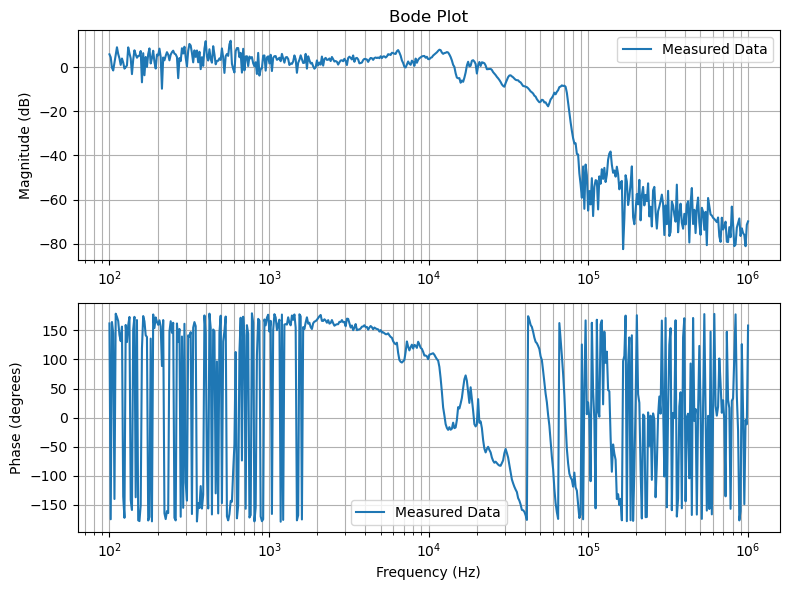

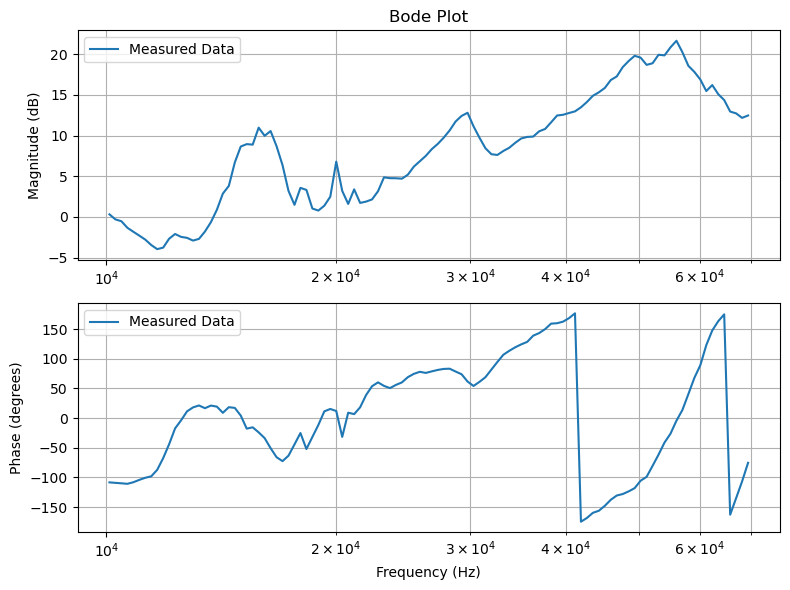

In [3]:
data = moku_read_TF_B(r"C:\Users\torre\Downloads\filter_upload_test_data_20250422_145919_Traces.csv")

mask = (data[0] > 1e4) & (data[0] < 7e4)

complex_data = db2mag(data[1])*np.exp(1j*(data[2])*np.pi/180)
rescale = np.average(np.abs(complex_data[-10:-1]))
rescaled_complex_data = complex_data/rescale
inverted = 1/np.array(rescaled_complex_data)[mask]

plot_bode(data[0],[np.array(complex_data)],["Measured Data"])
plot_bode(np.array(data)[0][mask],[np.array(inverted)],["Measured Data"])

# Downsample, fit, and convert to SOS

3W   0.01  Fitter_checkpoint improvement succeed, None
3W   0.02    Fitter_checkpoint improvement succeed, None
3W   0.05  Fitter_checkpoint improvement succeed, None
3W   0.08    Fitter_checkpoint improvement succeed, None
3W   0.22    Fitter_checkpoint improvement succeed, None
3W   0.55  Fitter_checkpoint improvement succeed, None
3W   1.86    Fitter_checkpoint improvement succeed, None


4


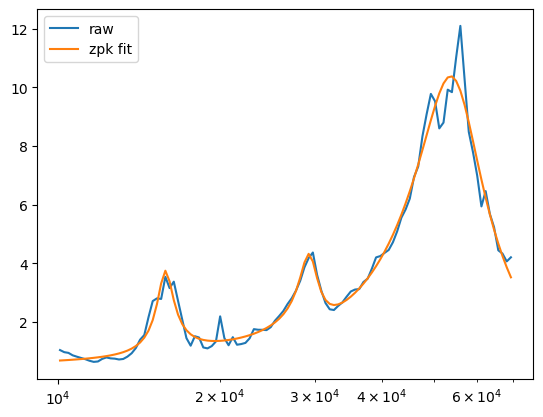

In [8]:
fit_fq = np.array(data[0][mask])[::-1]
fit_mag = np.abs(inverted[::-1])

fq_d, asd_d = downsample_data(fit_fq, fit_mag, 55) #CHANGE THIS NUMBER

with contextlib.redirect_stdout(io.StringIO()): #supressing the print statements, delete this line if you need to trouble shoot
    psdzpk, psdbunch = PSD2filter(
        fq_d,
        fit_fq,
        fit_mag**2,
        -2,
    )
E_zpk = psdzpk
E_fr = E_zpk.fresponse(f=np.array(data)[0][mask])

#Sanity check the fit is working
plt.semilogx(fit_fq,fit_mag,label = 'raw')
#plt.semilogx(dwn['freq'],dwn['ASD'],label = 'down sampled')
plt.semilogx(*E_fr.fplot_mag,label = 'zpk fit')
plt.legend()
moku_data = zpk2mokuIIR(E_zpk.z,E_zpk.p,E_zpk.k,)

# Convert to Moku Approved Text File

In [ ]:
#write to text file
filter_gain = 10.0
with open("output.txt", "w") as f:
    f.write(f"{filter_gain}\n")
    for row in moku_data:
        line = ", ".join(f"{x:.16f}" for x in row)  # Keeps full precision
        f.write(line + "\n")